<a href="https://colab.research.google.com/github/RetiefLouw/babaloon-data-exploration/blob/main/data_exploration_on_babaloon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

Read the 2 CSVs, join them and place the final dataset in joined_df

In [24]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

import numpy as np
import torch
import random


In [25]:
# # Load the data into a pandas DataFrame from local file
# data_path = "babaloon_kws_keywords - train_per_test.csv"
# scores_csv_filepath = "babaloon_kws_keywords - Scores.csv"

# Using online hosted files from 2024-03-26
data_path = 'https://raw.githubusercontent.com/RetiefLouw/babaloon-data-exploration/main/babaloon_kws_keywords%20-%20train_per_test.csv'
scores_csv_filepath = "https://raw.githubusercontent.com/RetiefLouw/babaloon-data-exploration/main/babaloon_kws_keywords%20-%20Scores.csv"

output_csv_path = "babaloon_kws_keywords - flattened.csv"
my_test_size = 0.2  # 20% for testing
my_random_state = 42

## Compile the list of unique words from the CSV


In [26]:
import csv
import json

# Define an empty list to store unique words
word_list = []
df = pd.read_csv(data_path)

# Skip the header row (if it exists)
if "header" in df.columns:
    df = df.iloc[1:]  # Assuming header is in the first row

# Loop through each row in the DataFrame
for index, row in df.iterrows():
    # Get the JSON string from the second column (assuming it's the second)
    json_data = row[1]

    # Fix any single quotes within the JSON string
    json_data = json_data.replace("'", '"')

    # Convert the JSON string to a dictionary
    data_dict = json.loads(json_data)

    # Extract unique words from the dictionary keys and add them to the list
    for word in data_dict.keys():
        if word not in word_list:
            word_list.append(word)

# Print the unique word list
word_list.sort()
print(f"Unique words: {word_list}")
print(f"Number of unique words: {len(word_list)}")

Unique words: ['babaloon', 'balloon', 'boom', 'butterfly', 'gelukkig', 'geëet', 'hardloop', 'hond', 'honger', 'kat', 'katjie', 'kwaad', 'lekker', 'muis', 'seer', 'seuntjie', 'sien', 'vissies', 'voel', 'water', 'wil', 'worsies']
Number of unique words: 22


## Flatten and populate the feature columns from the dictionary


In [27]:
# Read the original CSV
data = pd.read_csv(data_path)

# Initialize new columns with zeros
for word in word_list:
    data[word] = 0

# Save the updated DataFrame to the new CSV file (append mode)
data.to_csv(output_csv_path, header=True, index=False)

# print(data.head()) # Display the head of the new CSV with only 0s

In [28]:
# Load data from new csv and extract word counts
data = pd.read_csv(output_csv_path)

for index, row in data.iterrows():
    json_data = row["Keyword count"]
    json_data = json_data.replace("'", '"')
    data_dict = json.loads(json_data)

    # Update the 0 value of the column matching the "key" word
    for word in data.columns[
        3:
    ]:  # Assuming columns from the 4th position onward are the words columns
        if word in data_dict:
            data.at[index, word] = data_dict[word]

data.to_csv(output_csv_path, header=True, index=False)
# print(data.head()) # Display the flattened table

scores_only = pd.read_csv(scores_csv_filepath)
# print(scores_only.head())

# Perform an inner join
joined_df = pd.merge(data, scores_only, left_on="ID", right_on="filename", how="inner")

# Drop the redundant 'Filename' column if needed
joined_df = joined_df.drop("filename", axis=1)

# Save the updated DataFrame to the new CSV file (append mode)
joined_df.to_csv(output_csv_path, header=True, index=False)

print(joined_df) # Display the result

                      ID                                      Keyword count  \
0   id_10_main_post_test  {'wil': 7, 'butterfly': 3, 'gelukkig': 1, 'kat...   
1    id_10_main_pre_test  {'wil': 3, 'muis': 3, 'boom': 3, 'balloon': 3,...   
2   id_11_main_post_test  {'wil': 2, 'kat': 2, 'muis': 3, 'voel': 1, 'ba...   
3    id_11_main_pre_test  {'lekker': 1, 'boom': 3, 'seuntjie': 2, 'voel'...   
4   id_120_main_pre_test  {'muis': 2, 'voel': 3, 'babaloon': 2, 'worsies...   
..                   ...                                                ...   
56  id_94_main_post_test  {'wil': 8, 'muis': 6, 'geëet': 3, 'balloon': 7...   
57   id_94_main_pre_test  {'kat': 11, 'wil': 4, 'butterfly': 3, 'voel': ...   
58  id_95_main_post_test  {'wil': 4, 'kat': 2, 'boom': 3, 'hond': 9, 'kw...   
59   id_9_main_post_test  {'wil': 2, 'butterfly': 3, 'seer': 2, 'gelukki...   
60    id_9_main_pre_test  {'hond': 4, 'wil': 1, 'muis': 2, 'boom': 3, 'b...   

    Reviewed  babaloon  balloon  boom  butterfly  g

# Data Understanding

## Dataset Source

> The study commenced in February 2022. The main project focused on Xhosa and Afrikaans first language speaking children in preschools where the language of learning and teaching is in their mother tongue. Participants were selected from two districts in the Western Cape, Khayelitsha and Paarl East where homogeneous clusters of preschools fulfilling the language requirements of the
project could be found. As not all ECD centres are registered with the Department of Social Development, sites were also recruited in partnership with local NGO’s, namely Sikhula Sonke and Ikamva Labantu in Khayelitsha and Inceba Trust in Paarl. 28 Centres in Khayelitsha and 27 centres in Paarl East were identified and recruited to participate in the research study.

## Target Variable

### A17
A17 = sum of the narrative evaluation table
The table specifies 3 possible events which the child may describe in the story. The child earns a point each time they identify the initiation, goal, attempt, outcome or reaction of an event. The cild can earn an additional point by mentioning the setting of the story.

### D11
After answering the questions, the child is asked 11 questions to test the child's comprehension of the story elements. For each correct response from the child, the child is awarded 1 point. The maximum score achievable is 11.

> The story was then scored according to story structure elements used by the participant and a score out of /17 was compiled. Based on the story structure elements that were used, the researcher was then able to identify the level of structural complexity of each participant’s narrative.

## Determine Feature Data Types

In [29]:
# Print the data types of each column in the dataframe
print(joined_df.dtypes)

ID               object
Keyword count    object
Reviewed           bool
babaloon          int64
balloon           int64
boom              int64
butterfly         int64
gelukkig          int64
geëet             int64
hardloop          int64
hond              int64
honger            int64
kat               int64
katjie            int64
kwaad             int64
lekker            int64
muis              int64
seer              int64
seuntjie          int64
sien              int64
vissies           int64
voel              int64
water             int64
wil               int64
worsies           int64
A17              object
D11              object
dtype: object


`A17` and `D11` are displayed as `objects` instead of `int64` because the following 5 entries contain "`?`" characters:

```
*   id_33_main_post_test,??,7
*   id_42_main_pre_test,??,??
*   id_43_main_pre_test,??,??
*   id_48_main_post_test,??,2
*   id_111_main_pre_test,??,0
```

In [37]:
# Remove rows where 'A17' or 'D11' column contains '?'
joined_df = joined_df[~joined_df['A17'].str.contains('\?')]
joined_df = joined_df[joined_df['A17'].str.isnumeric()]
joined_df = joined_df[~joined_df['D11'].str.contains('\?')]
print(joined_df.dtypes)
# Convert columns A17 and D11 to integers
joined_df['A17'] = pd.to_numeric(joined_df['A17']).astype(int)
joined_df['D11'] = pd.to_numeric(joined_df['D11']).astype(int)

# Print the description of the dataframe
joined_df.describe()


ID               object
Keyword count    object
Reviewed           bool
babaloon          int64
balloon           int64
boom              int64
butterfly         int64
gelukkig          int64
geëet             int64
hardloop          int64
hond              int64
honger            int64
kat               int64
katjie            int64
kwaad             int64
lekker            int64
muis              int64
seer              int64
seuntjie          int64
sien              int64
vissies           int64
voel              int64
water             int64
wil               int64
worsies           int64
A17              object
D11              object
dtype: object


ValueError: Unable to parse string "6/9" at position 45


# Descriptive Statistics
## Central Tendency Measures

In [31]:
# prompt: calculate and print the Central Tendency Measures for joined_df

print(joined_df.describe())


        babaloon    balloon       boom  butterfly   gelukkig      geëet  \
count  59.000000  59.000000  59.000000  59.000000  59.000000  59.000000   
mean    1.338983   0.796610   1.322034   1.084746   0.525424   0.576271   
std     2.453781   2.090864   1.746333   1.734917   0.953323   0.932246   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   1.000000   0.000000   0.000000   0.000000   
75%     2.000000   0.000000   3.000000   2.000000   1.000000   1.000000   
max    12.000000  10.000000   6.000000   8.000000   5.000000   4.000000   

        hardloop       hond     honger        kat  ...     lekker       muis  \
count  59.000000  59.000000  59.000000  59.000000  ...  59.000000  59.000000   
mean    0.305085   3.220339   0.677966   3.237288  ...   0.508475   1.711864   
std     0.793383   3.695607   0.859845   3.798089  ...   1.236972   2.141952   
min 

## Dispersion Measures
## Data Distribution Analysis

# Data Visualization
## Univariate Analysis
## Bivariate Analysis
## Multivariate Analysis

# Correlation Analysis
## Correlation Matrices
### Pearson's Correlation (Numerical Features)
### Cramer's V and Theil's U (Categorical Features)
## Interpret Correlation Coefficients
## Identify Multicollinearity

# Missing Value Treatment
## Identify Missing Values
## Determine Missing Value Pattern
## Imputation Techniques
### Numerical Features
#### Mean/Median Imputation
#### Regression Imputation
### Categorical Features
#### Mode Imputation
#### Constant Value Imputation
## Evaluate Missing Value Treatment Impact

# Outlier Detection and Treatment
## Identify Outliers
### Univariate Methods
### Multivariate Methods
## Evaluate Outlier Impact
## Outlier Treatment
### Removal
### Capping
### Transformation

# Feature Engineering
## Create New Features
## Encode Categorical Variables
### One-Hot Encoding
### Label Encoding
## Feature Scaling/Normalization

# Dimensionality Reduction (optional)
## Principal Component Analysis (PCA)
## t-SNE
## Feature Selection Techniques
### Filter Methods
### Wrapper Methods
### Embedded Methods

# Data Preparation for Modeling
## Split into Training and Testing Sets
## Ensure Proper Data Format

The Babaloon dataset was recorded from

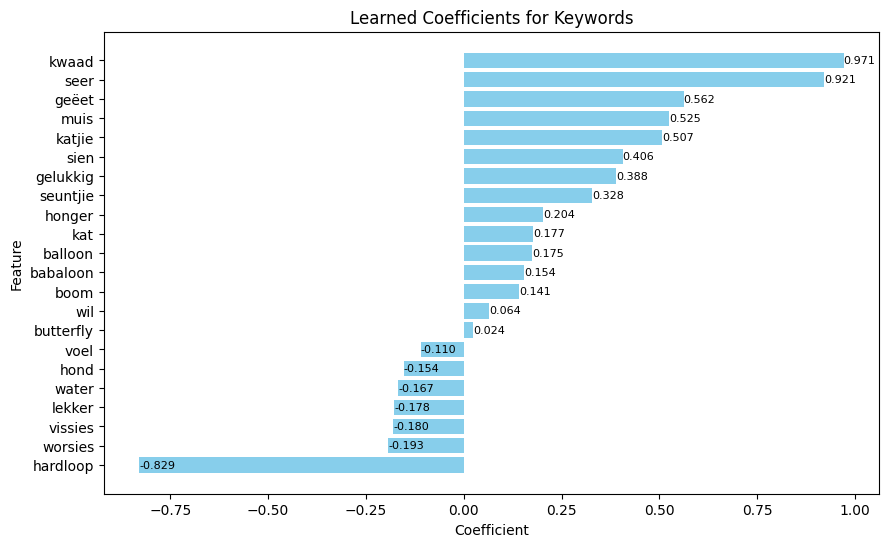

In [32]:
# Remove rows where 'A17' or 'D11' column contains '?'
joined_df = joined_df[~joined_df['A17'].str.contains('\?')]
joined_df = joined_df[joined_df['A17'].str.isnumeric()]
joined_df = joined_df[~joined_df['D11'].str.contains('\?')]

# Set features to everything between Reviewed and A17
features = joined_df.loc[
    :,
    joined_df.columns[
        (joined_df.columns.get_loc("Reviewed") + 1) : joined_df.columns.get_loc("A17")
    ],
]
# print(features)

target = joined_df["A17"]
# target = joined_df["D11"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=my_random_state
)

# # Standardize the features if necessary (optional)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Create and train the linear regression model and predict on the test set
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Get the coefficients and corresponding feature names
coefficients = model.coef_
feature_names = X_train.columns
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Create a bar chart
coefficients_df = coefficients_df.sort_values(by="Coefficient")
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df["Feature"], coefficients_df["Coefficient"], color="skyblue")
bars = plt.barh(
    coefficients_df["Feature"], coefficients_df["Coefficient"], color="skyblue"
)

# Add labels to the bars
for bar, label in zip(bars, coefficients_df["Coefficient"]):
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"{label:.3f}",
        va="center",
        ha="left",
        fontsize=8,
    )
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Learned Coefficients for Keywords")
plt.show()

# Print the coefficients
# print(coefficients_df)

# # Print results table
# print("\nFilename \t\t\t\t| True Value \t| Prediction \t| Error ")
# print("-" * 60)  # Adjust length for new column

# for row_index, (true_value, prediction, error) in enumerate(
#     zip(y_test, predictions, y_test - predictions)
# ):
#     # Extract filename from data DataFrame
#     filename = data.loc[row_index, "ID"].split("_")[1:3]
#     print(f"{filename} \t\t| {true_value:.2f} \t\t| {prediction:.2f} \t\t| {error:.2f}")

### Plot the model results for SciKit Learn

In [33]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Number of input features:\t\t{features.shape[1]}')
print(f'Number of instances:\t\t\t{joined_df.shape[0]}\n')

print(f"Mean Squared Error Train:\t\t{mse_train}")
print(f"Mean Squared Error Test:\t\t{mse_test}\n")

print(f"Root Mean Squared Error Train:\t\t{np.sqrt(mse_train)}")
print(f"Root Mean Squared Error Test:\t\t{np.sqrt(mse_test)}\n")

print(f"R-squared (R2) Train:\t\t\t{r2_train}")
print(f"R-squared (R2) Test:\t\t\t{r2_test}")

Number of input features:		22
Number of instances:			59

Mean Squared Error Train:		1.3561573560682
Mean Squared Error Test:		6.4975313047432905

Root Mean Squared Error Train:		1.1645416935722825
Root Mean Squared Error Test:		2.549025559845034

R-squared (R2) Train:			0.7173285903420783
R-squared (R2) Test:			0.15859306845050902


Slope for " seer " =  0.9737076648841352 



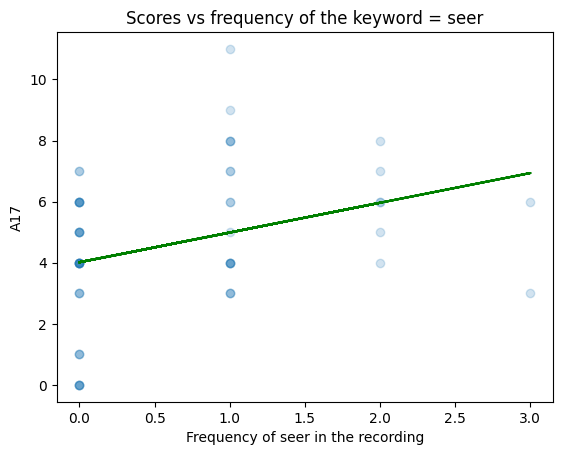

In [34]:
#  Create a scatter plot for a keyword vs A17
keyword = 'seer'
plot_dataframe = pd.DataFrame({keyword: joined_df[keyword], 'A17': joined_df['A17']})
plot_dataframe['A17'] = plot_dataframe['A17'].astype(int)

plt.scatter(plot_dataframe[keyword], plot_dataframe['A17'], alpha = 0.2)
plt.xlabel('Frequency of ' + keyword + ' in the recording')
plt.ylabel('A17')
plt.title("Scores vs frequency of the keyword = " + keyword)

# Plot the line of best fit
X = np.array(plot_dataframe[keyword]).reshape((-1, 1))
y = np.array(plot_dataframe['A17'])
model = LinearRegression()
model.fit(X, y)
slope = model.coef_[0]
intercept = model.intercept_
print('Slope for \"', keyword, '\" = ', slope, '\n')
plt.plot(X, slope * X + intercept, color='green')
plt.show()

## Using PyTorch

In [35]:
# df = joined_df  # Set the data variable from the prepared dataframe
# my_learning_rate = 0.01
# num_epochs = 40
# my_seed = 0
# np.random.seed(my_seed)
# torch.manual_seed(my_seed)
# random.seed(my_seed)
# #  lambda in scikit learn for regularisation

# target = joined_df["A17"]
# # target = joined_df["D11"]

# # Set features to everything between Reviewed and A17
# features = joined_df.loc[
#     :,
#     joined_df.columns[
#         (joined_df.columns.get_loc("Reviewed") + 1) : joined_df.columns.get_loc("A17")
#     ],
# ]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     features, target, test_size=my_test_size, random_state=my_seed
# )

# # Convert data to NumPy arrays and then to PyTorch tensors
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# # Define the linear regression model
# class LinearRegressionModel(nn.Module):
#     def __init__(self, input_size):
#         super(LinearRegressionModel, self).__init__()
#         self.linear = nn.Linear(input_size, 1)

#     def forward(self, x):
#         return self.linear(x)

# # Instantiate the model
# input_size = X_train_tensor.shape[1]
# model = LinearRegressionModel(input_size)

# # Define loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=my_learning_rate)

# # Training loop
# train_losses = []
# validation_losses = []

# for epoch in range(num_epochs):
#     # Forward pass for training data
#     outputs = model(X_train_tensor)
#     loss = criterion(outputs, y_train_tensor.view(-1, 1))
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     train_losses.append(loss.item())

#     # Forward pass for validation data
#     with torch.no_grad():
#         val_outputs = model(X_test_tensor)
#         val_loss = criterion(val_outputs, y_test_tensor.view(-1, 1))
#         validation_losses.append(val_loss.item())

# # Plot the training and validation loss curves on the same plot
# plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
# plt.plot(range(1, num_epochs + 1), validation_losses, label="Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss Curves with PyTorch")
# plt.legend()
# plt.show()

# # Evaluation on test set
# with torch.no_grad():
#     y_pred = model(X_test_tensor)

# mse = mean_squared_error(y_test, y_pred.numpy())
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred.numpy())

# print(f"Mean Squared Error (MSE): \t\t{mse}")
# print(f"Root Mean Squared Error (RMSE): \t{rmse}")
# print(f"R-squared (R2): \t\t\t{r2}")

# learned_coefficients = model.linear.weight.squeeze().tolist()
# feature_names = list(features.columns)

# coefficients_df = pd.DataFrame(
#     {"Feature": feature_names, "Coefficient": learned_coefficients}
# )
# # Sort the DataFrame by the 'Feature' column
# coefficients_df.sort_values(by="Feature", inplace=True)
# # print(coefficients_df) # Print the sorted DataFrame

# # Create a bar chart
# coefficients_df = coefficients_df.sort_values(by="Coefficient")
# plt.figure(figsize=(10, 6))
# plt.barh(coefficients_df["Feature"], coefficients_df["Coefficient"], color="skyblue")
# bars = plt.barh(
#     coefficients_df["Feature"], coefficients_df["Coefficient"], color="skyblue"
# )

# # Add labels to the bars
# for bar, label in zip(bars, coefficients_df["Coefficient"]):
#     plt.text(
#         bar.get_width(),
#         bar.get_y() + bar.get_height() / 2,
#         f"{label:.3f}",
#         va="center",
#         ha="left",
#         fontsize=8,
#     )
# plt.xlabel("Coefficient")
# plt.ylabel("Feature")
# plt.title("Learned Coefficients for Keywords")
# plt.show()